# Experiment: What is the best split criteria for RF Regression?

Vivek Gopalakrishnan | October 16, 2019


## My Random Forest setup

Split criteria being tested:

1. Mean Absolute Error (MAE)
2. Mean Squared Error (MSE)
3. Axis projections
4. Random projections


## My sampling model for synthetic data

Input data is sampled from a $d$-dimensional multivariate normal (MVN) and the output data is a random rotation of the input data.

Specifically,
$$
X_i \sim \text{MVN}\left(\mu, I_d\right) \,, y_i = AX_i \\
\mathcal{D}_n = \{(X_i, y_i)\} \text{ for } i=1,\dots,n
$$
where $A$ is a random rotation matrix sampled according to [the Haar distribution](http://scipy.github.io/devdocs/generated/scipy.stats.ortho_group.html) and $d$ is the number of simulated features.


## What simulations are run in this notebook?

Simulation parameters are `(n_samples, n_dim)`. I run the following simulations:

1. Increase `n_samples`, fix `n_dim=2`
2. Increase `n_dim`, fix `n_samples=50`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from simulation import generate_random_data, measure_mse, run_simulation

In [2]:
%load_ext autoreload
%autoreload 2

## Demo of simulation functions

The module `simulation` provides two functions:
1. `generate_random_data`: sample data according to the model above
2. `measure_mse`: for a given set of sample data, measure the MSE for all split criteria

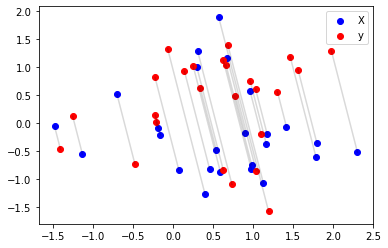

In [3]:
# Test data generation function
X, y = generate_random_data(n_samples=25, n_dim=2)

# 

plt.scatter(X[:, 0], X[:, 1], c="blue", label="X")
plt.scatter(y[:, 0], y[:, 1], c="red", label="y")

# Plot lines between matched pairs of points
for xi, yi in zip(X, y):
    plt.plot(
        [xi[0], yi[0]], 
        [xi[1], yi[1]], 
        c="black", 
        alpha = 0.15
    )

plt.legend()
plt.show()

In [4]:
# Test MSE measuring function
measure_mse(X, y)

[0.18257165633974426,
 0.1876376031067627,
 0.20506820607212906,
 0.20732911936208928]

## Simulation

Measure the effect of sample size on MSE. Choose $n=10, 20, \dots, 200$.

In [5]:
simulation_params = {
    "n_samples": np.arange(10, 201, 10),
    "n_dim": np.arange(2, 11, 1),
    "n_iter": 10,
}

In [6]:
df = run_simulation(simulation_params)

Number of dimensions:   0%|          | 0/9 [00:00<?, ?it/s]

Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

Iterations:  10%|█         | 1/10 [00:03<00:29,  3.23s/it]

Iterations:  20%|██        | 2/10 [00:06<00:25,  3.24s/it]

Iterations:  30%|███       | 3/10 [00:09<00:22,  3.28s/it]

Iterations:  40%|████      | 4/10 [00:13<00:19,  3.33s/it]

Iterations:  50%|█████     | 5/10 [00:16<00:16,  3.37s/it]

Iterations:  60%|██████    | 6/10 [00:19<00:13,  3.25s/it]

Iterations:  70%|███████   | 7/10 [00:23<00:09,  3.26s/it]

Iterations:  80%|████████  | 8/10 [00:26<00:06,  3.18s/it]

Iterations:  90%|█████████ | 9/10 [00:29<00:03,  3.16s/it]

Iterations: 100%|██████████| 10/10 [00:32<00:00,  3.26s/it]

Number of dimensions:  11%|█         | 1/9 [00:32<04:20, 32.56s/it]

Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

Iterations:  10%|█         | 1/10 [00:03<00:30,  3.34s/it]

Iterations:  20%|██        | 2/10 [00:06<00:26,  3.28s/it]

Iterations:  30%|███       | 3/10 [00:09<00:2

In [7]:
df

,n_samples,n_dim,split,mse
0,10,2,mae,0.281059
1,10,2,mae,0.280522
2,10,2,mae,0.282985
3,10,2,mae,0.276276
4,10,2,mae,0.222286
...,...,...,...,...
7195,200,10,oblique,0.220991
7196,200,10,oblique,0.218752
7197,200,10,oblique,0.210699
7198,200,10,oblique,0.214960


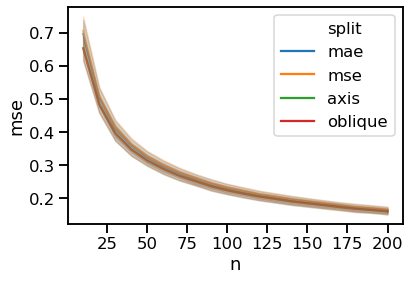

In [8]:
with sns.plotting_context("talk", font_scale=1):
    
    f = sns.lineplot(x="n_samples", y="mse", hue="split", data=df, alpha=0.5)
    f.set(xlabel="n", ylabel="mse")

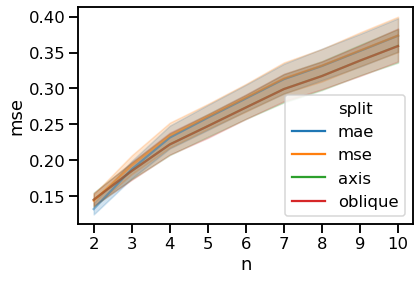

In [9]:
with sns.plotting_context("talk", font_scale=1):
    
    f = sns.lineplot(x="n_dim", y="mse", hue="split", data=df, alpha=0.5)
    f.set(xlabel="n", ylabel="mse")